In [1]:
"""
Anconda (Python 3.7) configuration
- install anaconda 3.7 on your system
- open terminal with anaconda active
- create new python environment for cinrad 'conda create -n myenv python=3.7'
- activate the cinrad environment (this will need to be done everytime you reopen the terminal or change environment)
- install pyart, cartopy and numpy ' conda install -c conda-forge cartopy numpy arm_pyart'

to run the code either use
- use your new cinrad environment from pycharm - https://medium.com/infinity-aka-aseem/how-to-setup-pycharm-with-an-anaconda-virtual-environment-already-created-fb927bacbe61
- use the jupyter notebooks edittor that is included in anaconda - type into active terminal 'jupyter notebook'

# example from Nanjing - https://github.com/zxdawn/pyart/blob/CNRAD/notebooks/Reading_S_band_radar_en.ipynb
Done!
"""


#system libraries
import glob
import os

#central libraries
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs # A toolkit for map projections
import cartopy.io.img_tiles as img_tiles 


#pyart libraries
import pyart
import sband_archive


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/meso/miniconda3/envs/radar-dev/lib/python3.6/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/home/meso/miniconda3/envs/radar-dev/lib/python3.6/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [2]:
#configuration block

#path to data
source_path = '/home/meso/dev/luzhou_radar_20190424/cinrad_data' #these are *.bin files
image_path  = '/home/meso/dev/luzhou_radar_20190424/images'

#location and altitude of radar (not in bin files currently)
radar_lat   = 29.5219
radar_lon   = 106.4889
radar_alt   = 438.8
#full list of CMA radar stations here: https://github.com/expertyang/read_cinrad/blob/master/radar_info.txt

#list of sweep indicies which contain reflectivity (note that sweeps 1 and 3 only contain radial velocity)
valid_sweep_list = [0,2,4,5,6,7,8,9,10]
#name of reflectivity field
plot_field  = 'reflectivity'
#sweep index for plotting
plot_sweep  = 2

# colormap types and ranges
if plot_field == 'reflectivity':
    vmin = -8
    vmax = 64
    cmap = 'pyart_HomeyerRainbow'
if plot_field == 'velocity':
    vmin = -15
    vmax = 15
    cmap = 'BuDRd18'

#setup map extend and lat/lon lines
map_range  = 1.6 #degrees
line_space = 0.2 #degrees
min_lat    = radar_lat - map_range
max_lat    = radar_lat + map_range
min_lon    = radar_lon - map_range
max_lon    = radar_lon + map_range
lat_lines  = np.arange(min_lat, max_lat+line_space, line_space)
lon_lines  = np.arange(min_lon, max_lon+line_space, line_space)

#map panel cuts
map_panel_axes = [0.05, 0.05, .4, .80]
x_cut_panel_axes = [0.55, 0.10, .4, .25]
y_cut_panel_axes = [0.55, 0.50, .4, .25]

#RHI slice azimuth
rhi1_azi = 92
rhi2_azi = 180

#read file list from data directory
data_ffn_list = sorted(glob.glob(source_path + '/*.bin'))

In [3]:
def plot_marker(city_lon, city_lat, city_name):

    plt.plot(city_lon, city_lat,
            'wo',
            markersize=10,
            markeredgecolor='k',
            transform=ccrs.Geodetic())
    
    plt.text(city_lon-0.02, city_lat+0.02, city_name,
         horizontalalignment='right',
         size=18, color='k',weight="bold",
         transform=ccrs.Geodetic())

def plot_data(data_ffn, output_filename):
    
    #read data
    radar = sband_archive.read_sband_archive(data_ffn, station=(radar_lat, radar_lon, radar_alt))
    #extract sweeps which have reflectivity
    radar = radar.extract_sweeps(valid_sweep_list)
    #create rhi slices
    xsect = pyart.util.cross_section_ppi(radar, [rhi1_azi, rhi2_azi])
    #create pyart display object for plotting
    ppi_display = pyart.graph.RadarMapDisplay(radar)
    rhi_display = pyart.graph.RadarDisplay(xsect)
    
    ############## Panel 1: PPI plot
    #generate request for mapping tiles
    stamen_terrain = img_tiles.Stamen('terrain-background')
    #create axis
    ax1 = fig.add_axes(map_panel_axes, projection=stamen_terrain.crs)
    ax1.set_extent([min_lon,max_lon,min_lat,max_lat])
    #add stamen tiles
    ax1.add_image(stamen_terrain, 8)
    #plot ppi
    ppi_display.plot_ppi_map(plot_field, plot_sweep,
                            projection=stamen_terrain.crs, resolution='10m',
                            vmin=vmin, vmax=vmax, 
                            max_lat = max_lat, min_lat = min_lat, min_lon = min_lon, max_lon = max_lon,
                            cmap = cmap)
    
    #add grid lines and set style
    gl = ppi_display.ax.gridlines(draw_labels=True,
                                  linewidth=2, color='gray', alpha=0.9,
                                  linestyle='--')
    #set plot x and y label styles and visibility
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}
    gl.xlabels_top = False
    gl.ylabels_right = False
    #plot RHI lines
    ppi_display.plot_line_xy([0,100000],[0,0],linestyle='-',color='r')
    ppi_display.plot_line_xy([0,0],[0,-100000],linestyle='-',color='b')
    
    #add markers ### EDIT THIS AS NEEDED
    plot_marker(105.442, 28.871, 'Luzhou')
    plot_marker(106.566, 29.558, 'Chongqing')
    
    ################### Panel 2: longitude slice
    ax2 = fig.add_axes(x_cut_panel_axes)
    rhi_display.plot_rhi(plot_field, 0,
                             vmin=vmin, vmax=vmax,
                             cmap=cmap, title='90 Deg. RHI (red)')
    rhi_display.set_limits(ylim=[0, 10], xlim=(0, 100)) #height and range limits
    rhi_display.plot_grid_lines(ax=ax2, col='k', ls=':') #height and range limits

    ################### Panel 2: longitude slice
    ax3 = fig.add_axes(y_cut_panel_axes)
    rhi_display.plot_rhi(plot_field, 1,
                             vmin=vmin, vmax=vmax,
                             cmap=cmap, title='180 Deg. RHI (blue)')
    rhi_display.set_limits(ylim=[0, 10], xlim=(0, 100))
    rhi_display.plot_grid_lines(ax=ax3, col='k', ls=':')
    
    #save figure
    if output_filename is not None:
        plt.savefig(output_filename, dpi=100)
        plt.close()

/home/meso/dev/luzhou_radar_20190424/sband_archive.py:183: UserWarning: Gate spacing is not constant, interpolating data in scans [0, 2, 4, 5, 6, 7, 8, 9, 10] for moment REF.
  UserWarning)


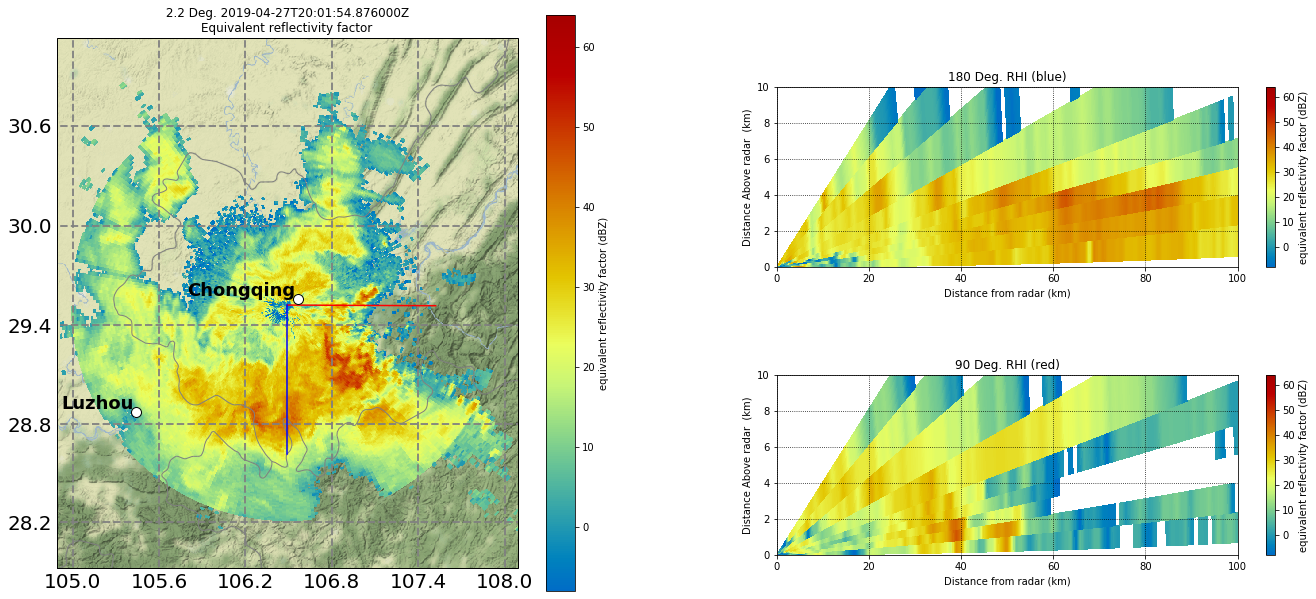

In [4]:
##Example 1: Plot a single data file

#create figure
fig = plt.figure(figsize=[20, 10], facecolor='w')

#select one data file to plot
test_data_ffn = data_ffn_list[0]
#plot data file
plot_data(test_data_ffn, None)


In [ ]:
#Example 2: Save plot images for all data files in the source folder

for data_ffn in data_ffn_list:
    #create image fn for output
    data_fn = os.path.basename(data_ffn)
    image_fn = image_path + '/' + data_fn[15:27] + '.png'
    #create figure
    fig = plt.figure(figsize=[15, 7], facecolor='w')
    #plot and save
    plot_data(data_ffn, image_fn)
    #close figure
    plt.close()
    #update
    print('finished:', data_ffn)


In [7]:
#make gif animation!

import imageio

image_list = sorted(glob.glob('images/*.png'))

with imageio.get_writer('images/movie.gif', mode='I',  duration=0.5) as writer:
    for filename in image_list:
        image = imageio.imread(filename)
        writer.append_data(image)
        print('added:', filename)


added: images/201904272000.png
added: images/201904272005.png
added: images/201904272010.png
added: images/201904272016.png
added: images/201904272021.png
added: images/201904272027.png
added: images/201904272032.png
added: images/201904272038.png
added: images/201904272043.png
added: images/201904272049.png
added: images/201904272054.png
added: images/201904272100.png
added: images/201904272105.png
added: images/201904272111.png
added: images/201904272116.png
added: images/201904272121.png
added: images/201904272127.png
added: images/201904272132.png


![football](images/movie.gif "animation")